- http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [141]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [29]:
# input_dim = 3, output_dim = 3
lstm = nn.LSTM(3, 3)

# seq_len = 5, input_size = 3
inputs = [Variable(torch.randn((1, 3))) for _ in range(5)]

# 隠れ状態を初期化
hidden = (Variable(torch.randn(1, 1, 3)),  # h_0
          Variable(torch.randn(1, 1, 3)))  # c_0

In [24]:
# 1. シーケンス内の各データを順番に渡す場合
for i in inputs:
    out, hidden = lstm(i.view(1, 1, -1), hidden)

In [30]:
# 2. シーケンスをまとめて入れる
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (Variable(torch.randn(1, 1, 3)),  # h_0
          Variable(torch.randn(1, 1, 3)))  # c_0
out, hidden = lstm(inputs, hidden)
# 各シーケンスを入れたときの出力（隠れ状態）が保存されている
print(out)
# 最後のシーケンスを入れたときの出力（隠れ状態）
# hとcの両方
# hidden[0]はout[-1] と等しい
print(hidden)

Variable containing:
(0 ,.,.) = 
  0.0701 -0.7037  0.1069

(1 ,.,.) = 
  0.3079 -0.5484 -0.0709

(2 ,.,.) = 
  0.0946 -0.2790 -0.1762

(3 ,.,.) = 
  0.2042 -0.2284  0.1237

(4 ,.,.) = 
  0.1507 -0.0625  0.2798
[torch.FloatTensor of size 5x1x3]

(Variable containing:
(0 ,.,.) = 
  0.1507 -0.0625  0.2798
[torch.FloatTensor of size 1x1x3]
, Variable containing:
(0 ,.,.) = 
  0.3439 -0.0723  0.5727
[torch.FloatTensor of size 1x1x3]
)


## An LSTM for Part-of-Speech Tagging

In [120]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return Variable(tensor)

In [121]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [122]:
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

tag_to_ix = {'DET': 0, 'NN': 1, 'V': 2}

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [123]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

In [124]:
class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
        # LSTMの隠れ状態はhiddenは (h_0, c_0)
        return (Variable(torch.zeros(1, 1, self.hidden_dim)),
                Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        # lstm_out[-1] と self.hidden[0] (h_0) が等しい
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1),
            self.hidden)
        # lstm_outは時系列を構成する各要素を入れたときの出力がすべて保存されている
        # LSTMTaggerは出力をすべて使う
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [132]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [133]:
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)

In [138]:
losses = []
for epoch in range(300):
    for sentence, tags in training_data:
        model.zero_grad()
        
        # 各文章ごとに内部状態をクリアする
        # そうしないと前の文章の最後の状態が次の文章の最初の状態になってしまう
        model.hidden = model.init_hidden()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        tag_scores = model(sentence_in)
        
        loss = loss_function(tag_scores, targets)
        losses.append(loss.data[0])

        loss.backward()
        optimizer.step()

inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(tag_scores)

Variable containing:
-0.0162 -4.3860 -5.6303
-6.9587 -0.0019 -6.9722
-3.8225 -3.7032 -0.0476
-0.0184 -4.6096 -4.7914
-5.6127 -0.0058 -6.1650
[torch.FloatTensor of size 5x3]



In [139]:
np.argmax(tag_scores.data.numpy(), axis=1)

array([0, 1, 2, 0, 1])

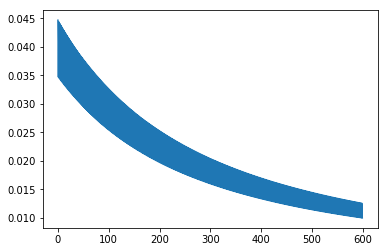

In [142]:
plt.plot(losses)